In [1]:
import tensorflow as tf

In [2]:
import pathlib

.zip 的内容被解压到基本目录 ~/.keras/datasets/horses 和 ~/.keras/datasets/humans，目录里包含马和人类的图片。

注意：
   这个数据集中并没有明确的将图像标记为马或人。稍后你将学习使用 ImageGenerator，ImageGenerator会适当的标记图像，减少编码步骤。
   
首先，定义每个目录。

In [3]:
path_to_file = tf.keras.utils.get_file(
    'horse-or-human.zip',
    cache_subdir='horse-or-human',
    origin='http://aimaksen.bslience.cn/horse-or-human.zip',
    extract=True
)

In [4]:
train_horses_dir = pathlib.Path(path_to_file).parent/'horses'
train_humans_dir = pathlib.Path(path_to_file).parent/'humans'

现在，让我们看看马和人类训练目录中的文件名：

In [5]:
import os
train_horses_names = os.listdir(train_horses_dir)
train_humans_names = os.listdir(train_humans_dir)

In [6]:
train_horses_names[0:10]

['horse43-5.png',
 'horse06-5.png',
 'horse20-6.png',
 'horse04-7.png',
 'horse41-7.png',
 'horse22-4.png',
 'horse19-2.png',
 'horse24-2.png',
 'horse37-8.png',
 'horse02-1.png']

In [7]:
train_humans_names[0:10]

['human17-22.png',
 'human10-17.png',
 'human10-03.png',
 'human07-27.png',
 'human09-22.png',
 'human05-22.png',
 'human02-03.png',
 'human02-17.png',
 'human15-27.png',
 'human12-12.png']

In [8]:
train_horses_names = os.listdir(train_horses_dir)
print(train_horses_names[:10])

['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']


让我们找出目录中马和人图像的总数：

In [9]:
train_humans_names = os.listdir(train_humans_dir)
print(train_humans_names[:10])

['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']


我们再来看几张图片。 首先，配置matplot参数：

In [10]:
len(train_humans_names)

527

In [11]:
len(train_horses_names)

500

In [12]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

现在，显示一个 batch, 每个 batch 包含了8幅马和8幅人的图片。 您可以多次运行下面的单元格。

In [13]:
nrows = 4
ncols = 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)



<Figure size 1152x1152 with 0 Axes>

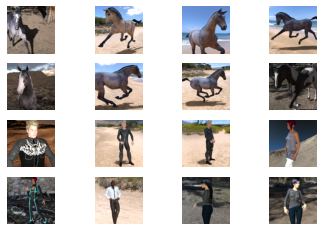

In [14]:
pic_index += 8
next_horses_pix = [
    os.path.join(train_horses_dir,fname) for fname in train_horses_names[pic_index - 8:pic_index]
]

next_humans_pix = [
    os.path.join(train_humans_dir,fname) for fname in train_humans_names[pic_index - 8:pic_index]
]


for i, img_path in enumerate(next_horses_pix + next_humans_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

## 从一个小模型开始搭建

先导入 tensorflow

In [15]:
import tensorflow as tf

### 数据处理

使用 ImageDataGenerator，用于一个批次一个批次的读取数据。每个批次有128张图片，每个图片 300X300。

[接口文档](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [17]:
train_data_gen = ImageDataGenerator(rescale = 1 / 255)

In [18]:
train_generator = train_data_gen.flow_from_directory(
    pathlib.Path(path_to_file).parent,
    target_size = (300, 300),
    batch_size=128,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [19]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [20]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [21]:
train_generator.filepaths[0]

'/Users/xlx/.keras/horse-or-human/horses/horse01-0.png'

In [22]:
train_generator.image_data_generator

### 搭建模型
我们先来搭建模型。

我们可以复用之前的 CNN 代码，并在原有基础上多加几层卷积和池化。

注意：
    horse-or-human 数据集对应的是二分类问题。所以在网络的最后一层，我们使用 sigmoid 激活函数。sigmoid 的输出是0/1。

In [23]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

2022-01-01 16:40:25.803901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.summary() 方法调用打印神经网络的网络层

In [24]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

Output Shape 列显示特征图的大小在连续层中的演变。


接下来编译模型，由于是二分类问题。所以我们使用的损失函数是 binary_crossentropy。在这里，我们使用了一个全新的优化器 RMSprop。


In [25]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [26]:
train_generator

我们训练15个 epoch —— 这可能需要几分钟才能运行。

In [27]:
model.fit(train_generator, steps_per_epoch=8,epochs = 5) 

Epoch 1/5
8/8 [==============================] - 24s 3s/step - loss: 3.1147 - accuracy: 0.5729
Epoch 2/5
8/8 [==============================] - 23s 3s/step - loss: 0.7436 - accuracy: 0.7264
Epoch 3/5
8/8 [==============================] - 23s 3s/step - loss: 0.5289 - accuracy: 0.8165
Epoch 4/5
8/8 [==============================] - 23s 3s/step - loss: 0.6217 - accuracy: 0.8598
Epoch 5/5
8/8 [==============================] - 22s 3s/step - loss: 0.5621 - accuracy: 0.8432


In [31]:
model.fit(train_generator, steps_per_epoch=8,epochs = 5) 

Epoch 1/5
8/8 [==============================] - 22s 3s/step - loss: 0.1358 - accuracy: 0.9466
Epoch 2/5
8/8 [==============================] - 22s 3s/step - loss: 0.1454 - accuracy: 0.9522
Epoch 3/5
8/8 [==============================] - 25s 3s/step - loss: 0.1053 - accuracy: 0.9531
Epoch 4/5
8/8 [==============================] - 23s 3s/step - loss: 0.1141 - accuracy: 0.9655
Epoch 5/5
8/8 [==============================] - 22s 3s/step - loss: 0.0852 - accuracy: 0.9711


### 测试

让我们使用训练好的模型做预测。

In [39]:
import numpy as np
from keras.preprocessing import image

path = os.path.join(train_horses_dir, train_horses_names[1])
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis = 0)
classes = model.predict(x, batch_size = 1)
print(classes[0])

if classes > 0.5:
    print('人')
else:
    print('马')

[1.9228948e-07]
马


In [40]:
import numpy as np
from keras.preprocessing import image

path = os.path.join(train_humans_dir, train_humans_names[1])
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis = 0)
classes = model.predict(x, batch_size = 1)
print(classes[0])

if classes > 0.5:
    print('人')
else:
    print('马')

[0.99908376]
人


In [30]:
classes

array([[0.00013816]], dtype=float32)

## 验证集使用

下载 validation-horse-or-human.zip 文件，以下的 cell 主要功能是访问文件系统，以及对 zip 文件解压缩。

下载链接：https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip 

In [58]:
validation_path_to_file = tf.keras.utils.get_file(
    'validation-horse-or-human',
    cache_subdir='validation-horse-or-human',
    origin='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip',
    extract=True
)

In [59]:
validation_horses_dir = pathlib.Path(validation_path_to_file).parent/'horses'
validation_humans_dir = pathlib.Path(validation_path_to_file).parent/'humans'

In [60]:
validation_horses_dir,validation_humans_dir

(PosixPath('/Users/xlx/.keras/validation-horse-or-human/horses'),
 PosixPath('/Users/xlx/.keras/validation-horse-or-human/humans'))

看看马和人类训练、验证目录中的文件名

In [68]:
validation_horses_names = os.listdir(validation_horses_dir)
validation_humans_names = os.listdir(validation_humans_dir)

In [69]:
validation_horses_names[0:10]

['horse1-204.png',
 'horse2-112.png',
 'horse3-498.png',
 'horse5-032.png',
 'horse5-018.png',
 'horse1-170.png',
 'horse5-192.png',
 'horse1-411.png',
 'horse4-232.png',
 'horse3-070.png']

查看训练、验证目录中马和人图像总数

In [70]:
len(validation_horses_names), len(validation_humans_names)

(128, 128)

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
validation_data_gen = ImageDataGenerator(rescale = 1 / 255)
validation_generator = train_data_gen.flow_from_directory(
    pathlib.Path(validation_path_to_file).parent,
    target_size = (300, 300),
    batch_size=32,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


In [74]:
model_2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [75]:
from tensorflow.keras.optimizers import RMSprop

model_2.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [77]:
model_2.fit(train_generator, steps_per_epoch=8,epochs = 5, validation_data=validation_generator) 

Epoch 1/5
8/8 [==============================] - 25s 3s/step - loss: 0.1364 - accuracy: 0.9522 - val_loss: 1.5625 - val_accuracy: 0.7891
Epoch 2/5
8/8 [==============================] - 24s 3s/step - loss: 0.2148 - accuracy: 0.9166 - val_loss: 0.4703 - val_accuracy: 0.8594
Epoch 3/5
8/8 [==============================] - 24s 3s/step - loss: 0.1976 - accuracy: 0.9221 - val_loss: 1.2975 - val_accuracy: 0.8242
Epoch 4/5
8/8 [==============================] - 25s 3s/step - loss: 0.1138 - accuracy: 0.9611 - val_loss: 1.2182 - val_accuracy: 0.8320
Epoch 5/5
8/8 [==============================] - 26s 3s/step - loss: 0.0446 - accuracy: 0.9900 - val_loss: 1.1244 - val_accuracy: 0.8047


## 从一个小模型开始搭建

第一步 导入 tensorflow:

第二步 构建模型:

model.summary() 方法调用打印神经网络的网络层:

第三步 编译:

第四步 数据处理:

使用 ImageDataGenerator，用于一个批次一个批次的读取数据。每个批次有128张图片，每个图片 300X300。

第五步 训练模型:

第六步 预测:

清理

在运行下一个练习之前，运行以下单元格以终止内核并释放内存资源：

## 探索压缩图片带来的影响